In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import pickle

2024-10-29 09:30:35.523153: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 09:30:35.559081: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 09:30:35.559125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 09:30:35.559956: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 09:30:35.564831: I tensorflow/core/platform/cpu_feature_guar

In [2]:
print(tf.__version__)
print(tf.config.list_physical_devices())

2.15.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-29 09:30:37.147794: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 09:30:37.193318: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-29 09:30:37.193358: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_virtual_device_configuration(
                gpu,
                [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4096)])  # Set your memory limit here
    except RuntimeError as e:
        print(e)

In [4]:
def inverse_convert_time_window(data_3d):
    samples, timesteps, variables = data_3d.shape
    data_2d = np.zeros((samples + timesteps - 1, variables))

    count = np.zeros((samples + timesteps - 1, variables))

    for i in range(samples):
        data_2d[i:i+timesteps] += data_3d[i]
        count[i:i+timesteps] += 1

    # Average the overlapping segments
    data_2d /= count
    return data_2d

In [5]:
def convert_time_window(data, timesteps):
    samples = data.shape[0] - timesteps + 1  # Number of samples in the new 3D array
    variables = data.shape[1]  # Number of variables (features)

    data_3d = np.zeros((samples, timesteps, variables))

    for i in range(samples):
        data_3d[i] = data[i:i+timesteps]
    return data_3d

In [6]:
def calculate_reconstruction_loss(data, reconstructions):
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    total_r_e = np.sum(reconstruction_errors)
    relative_reconstruction_errors = np.array([(r_e / total_r_e) * 100 for r_e in reconstruction_errors])
    return reconstruction_errors

In [7]:
def find_optimal_threshold(reconstruction_errors, y_true):
    from sklearn.metrics import accuracy_score, balanced_accuracy_score

    best_threshold = 0.0
    best_f1 = 0.0
    best_y_pred = np.zeros(reconstruction_errors.shape)
    # q3 = np.percentile(reconstruction_errors, 75)
    # q1 = np.percentile(reconstruction_errors, 25)
    # iqr = q3 - q1
    upper_bound = np.max(reconstruction_errors)
    lower_bound = np.min(reconstruction_errors)

    thresholds = np.linspace(lower_bound, upper_bound, num=1000)

    for threshold in thresholds:
        y_pred = np.where((reconstruction_errors > threshold) ,1, 0)
        # print(y_pred.shape)
        # print(y_true.shape)

        # Hitung F1-Score
        current_f1 = balanced_accuracy_score(y_true.astype(bool), y_pred.astype(bool))

        if current_f1 > best_f1:
            best_f1 = current_f1
            best_threshold = threshold
            best_y_pred = y_pred

    return best_threshold, best_f1, best_y_pred

# def find_optimal_threshold(reconstruction_errors, y_true):
#     from sklearn.metrics import f1_score, accuracy_score
    
#     best_threshold = 0.0
#     best_f1 = 0.0
#     best_y_pred = np.zeros(reconstruction_errors.shape)
#     q3 = np.percentile(reconstruction_errors, 75)
#     q1 = np.percentile(reconstruction_errors, 25)
#     iqr = q3 - q1
#     upper_bound = max(np.max(reconstruction_errors) / 2, (q3 + iqr * 1.5))
#     lower_bound = min(np.min(reconstruction_errors) / 2, (q1 - iqr * 1.5))

#     thresholds = np.linspace(lower_bound, upper_bound, num=500)

#     for threshold in thresholds:
#         y_pred = np.where(
#             (reconstruction_errors > (threshold + iqr)) | 
#             (reconstruction_errors < (threshold - iqr)),
#               1, 0)
#         # print(y_pred.shape)
#         # print(y_true.shape)

#         current_f1 = accuracy_score(y_true.astype(bool), y_pred.astype(bool))

#         if current_f1 > best_f1:
#             best_f1 = current_f1
#             best_threshold = threshold
#             best_y_pred = y_pred

#     return best_threshold, best_f1, best_y_pred

## ================================================================

In [8]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

df = pd.read_csv("../../datasets/turbine-gas-gearbox/BLD-LGC PTGBX 26 JUL21-8FEB23_edited.csv", index_col='Timestamp')
df.index = pd.to_datetime(df.index, format='mixed')

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)
pickle.dump(scaler, open('StandardScaler-gearbox.pkl', 'wb'))

In [9]:
df.index.shape

(161788,)

In [10]:
df.columns

Index(['PT N2 'C' Speed', 'Gear High Speed Drive End X Vibr',
       'Gear High Speed Drive End Y Vibr',
       'Gear High Speed Non-Drive End X Vibr',
       'Gear High Speed Non-Drive End Y Vibr', 'Gear LS Shaft Axial Displ 1',
       'Gear LS Shaft Axial Displ 2', 'Gear Low Speed Drive End X Vibr',
       'Gear Low Speed DriveEnd Y Vibr', 'Gear Low Speed Non-Drive End X Vibr',
       'Gear Low Speed Non-Drive End Y Vibr', 'PT Axial Displ 1',
       'PT Axial Displ 2', 'PT Coupling End X Vibr', 'PT Coupling End Y Vibr',
       'PT Disc End X Vibr', 'PT Disc End Y Vibr',
       'Gear H.S. Non-Drive End Jrnl Brg Temp',
       'Gear LS Outboard Thrust Brg Temp', 'Gear Drain Temp',
       'Gear H.S. Drive End Jrnl Brg Temp', 'Gear LS Drive End Jrnl Brg Temp',
       'Gear LS Inboard Thrust Brg Temp', 'LO Supply Press',
       'LO Cooler Outlet Temp', 'Pt Thrust Brg Temp', 'Pt Coupling End Temp',
       'Pt Disch End Temp', 'PT Rim Cooling 1&2 Temp',
       'PT Rim Cooling 3&4 Temp', 'Gea

array([<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>,
       <Axes: xlabel='Timestamp'>], dtype=object)

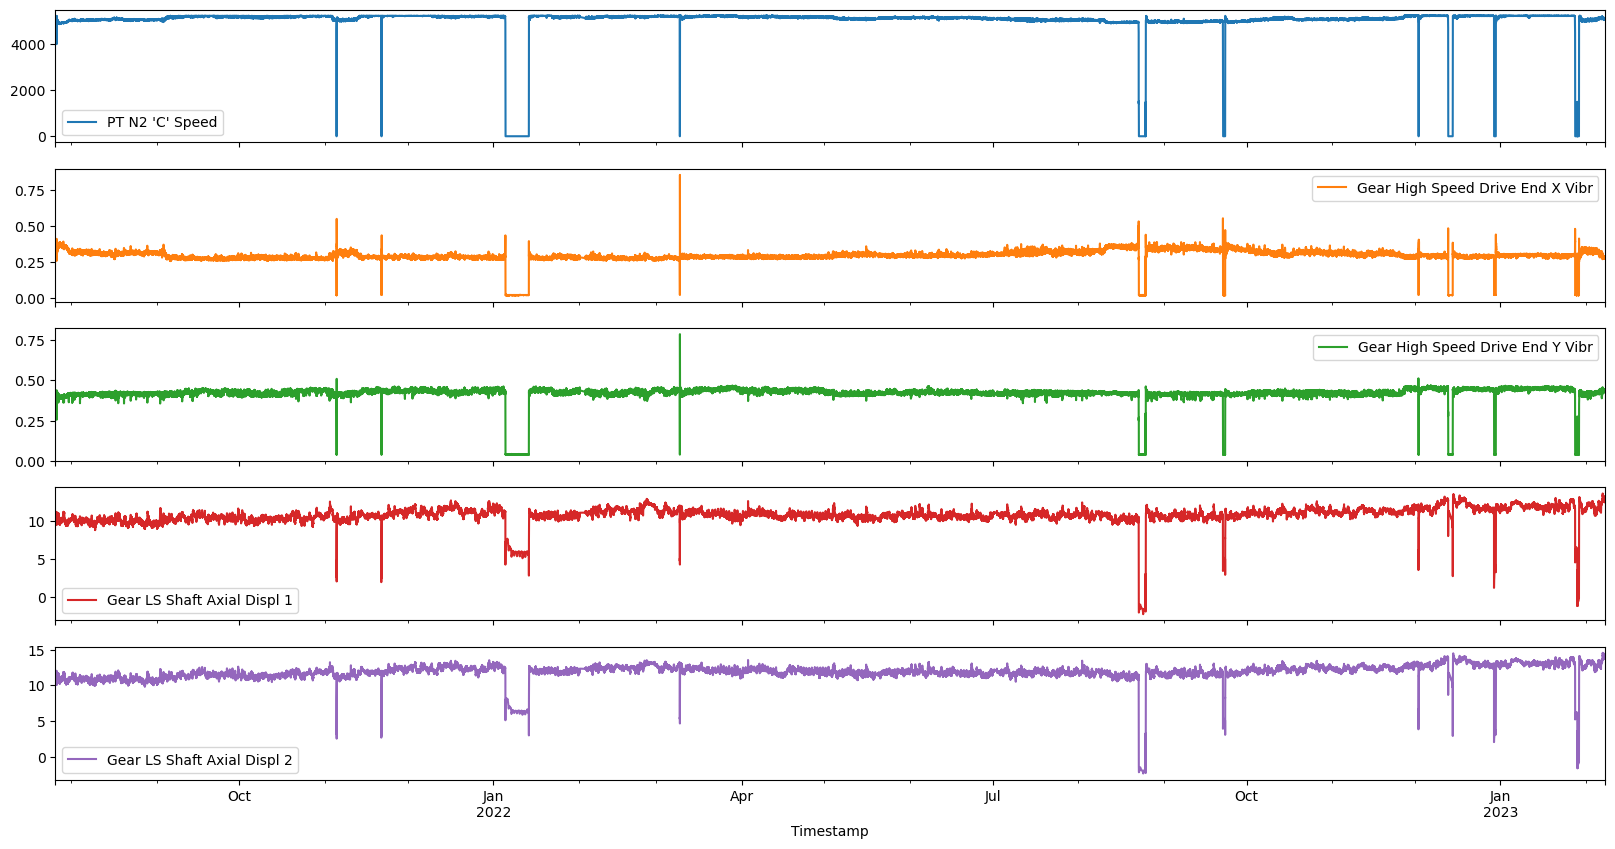

In [11]:
df[["PT N2 \'C\' Speed", 
    'Gear High Speed Drive End X Vibr',
    'Gear High Speed Drive End Y Vibr',
    'Gear LS Shaft Axial Displ 1',
    'Gear LS Shaft Axial Displ 2'
    ]].plot(figsize=(20,10), subplots=True)

/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


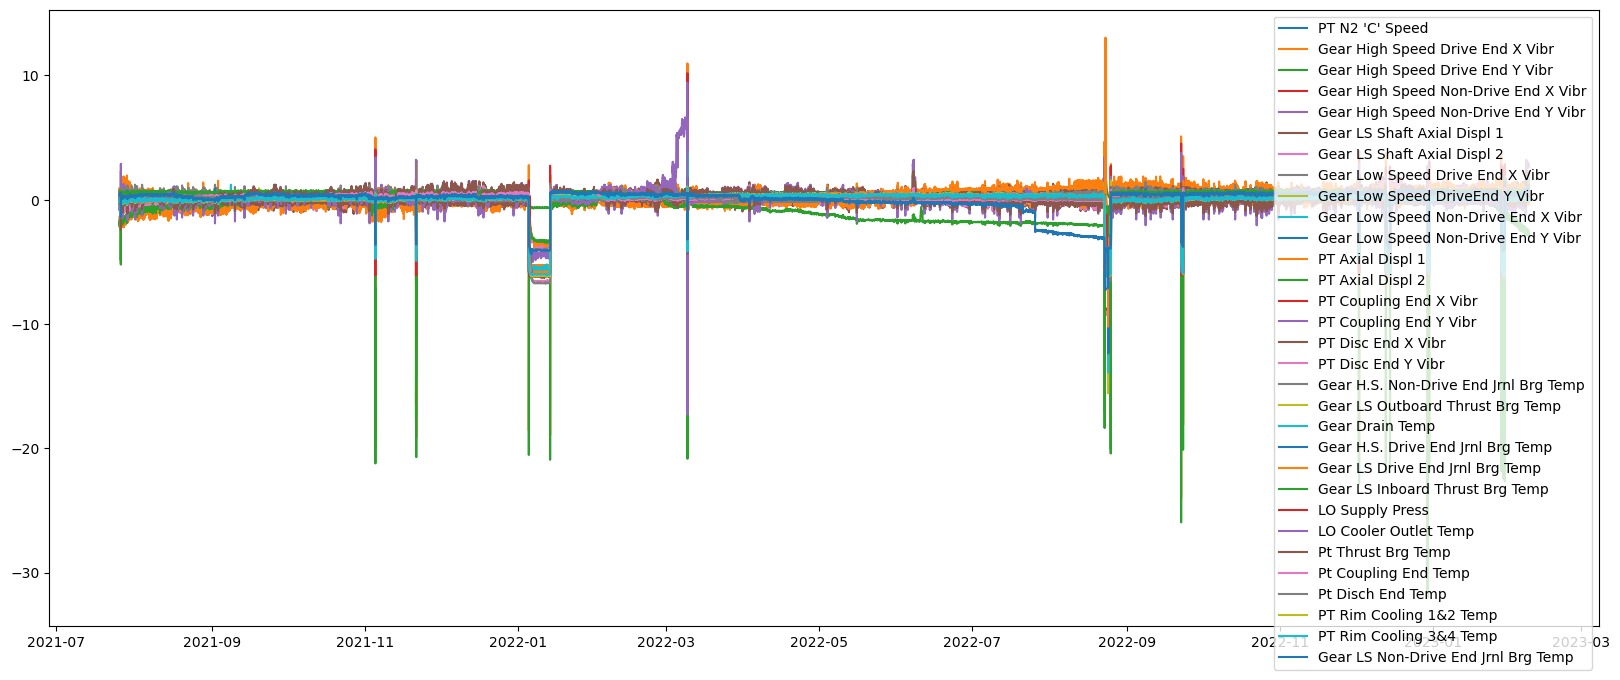

In [12]:
plt.figure(figsize=(20,8))
plt.plot(df.index, df_scaled, label=df.columns)
plt.legend()
plt.show()

In [13]:
df.shape
# if 'Gear LS Inboard Thrust Brg Temp' in df.columns:
#     df.drop('Gear LS Inboard Thrust Brg Temp', axis=1, inplace=True)

(161788, 31)

In [14]:
df_sample = df.reset_index().loc[:60000-1]
df_sample.to_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index=False)

In [15]:
df_sample_test = df.reset_index().loc[60000:70000-1]
df_sample_test.to_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index=False)

## ==========================================

In [16]:
df_sample = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample.csv", index_col="Timestamp")
print(df_sample.shape)

(60000, 31)


In [17]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import pickle

# scaler = MinMaxScaler([0,1])
scaler = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_scaled = scaler.transform(df_sample)

[]

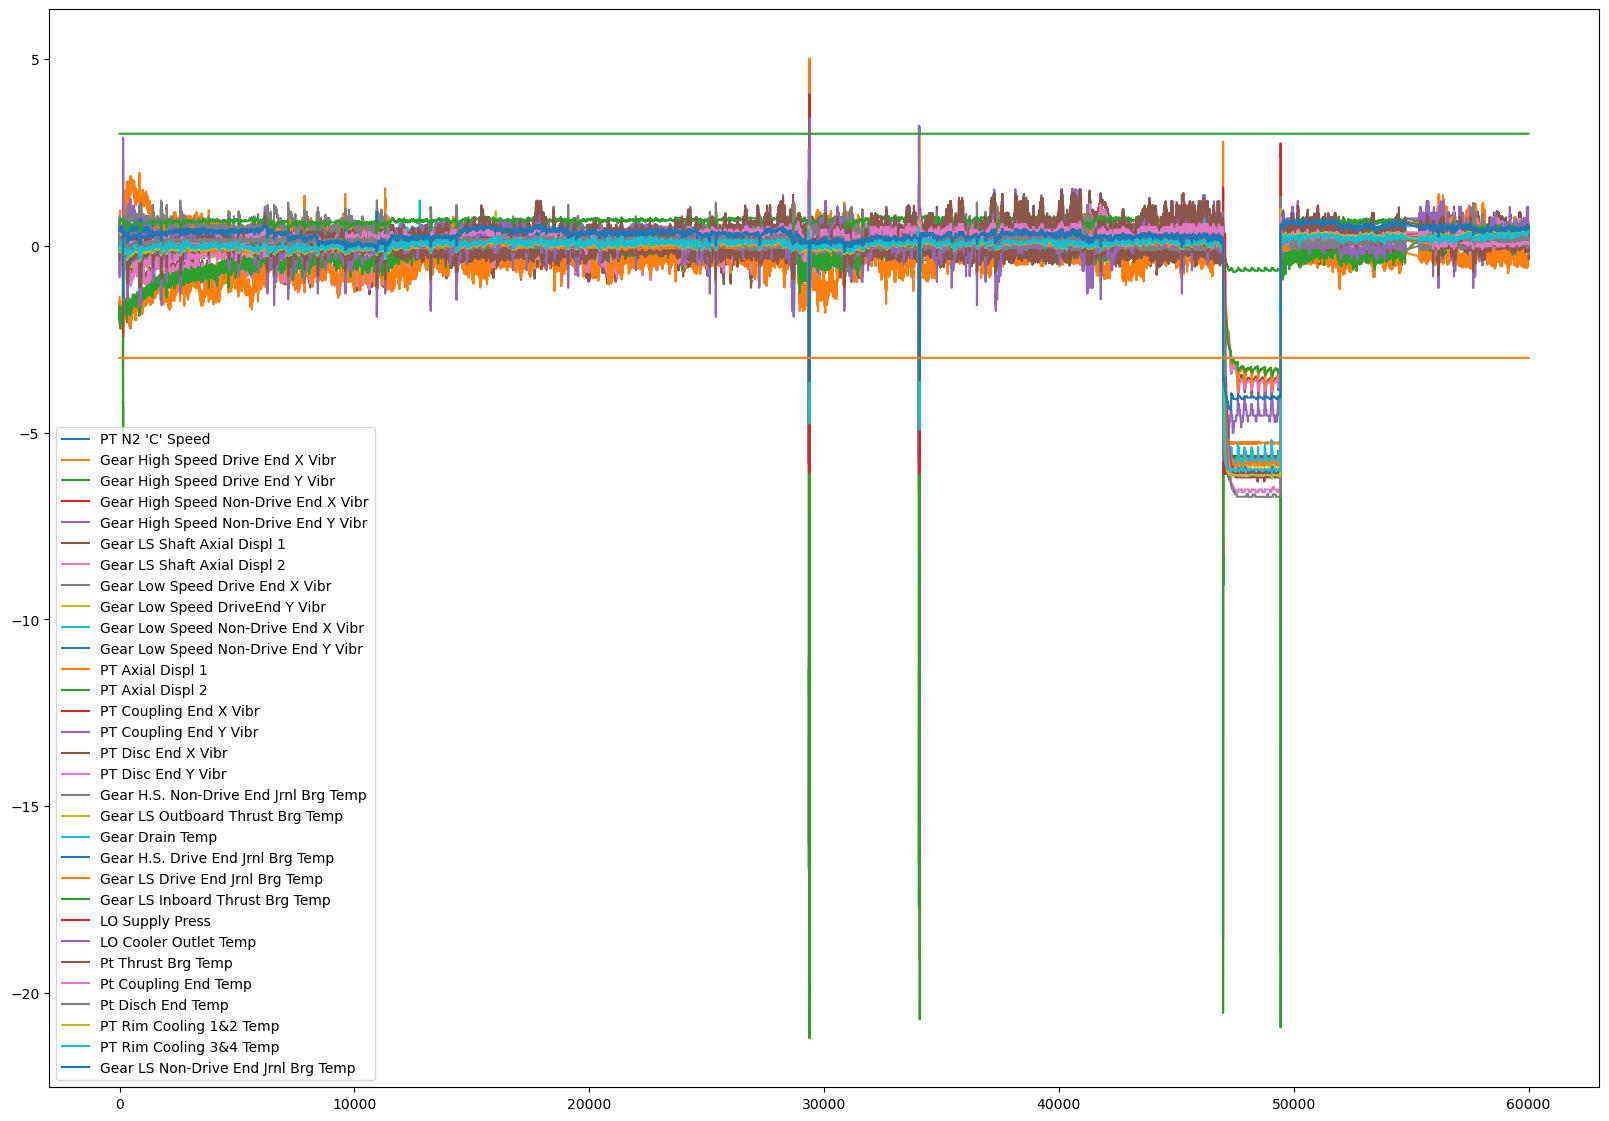

In [18]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
plt.plot(np.full(df_sample_scaled.shape[0], -3))
plt.plot(np.full(df_sample_scaled.shape[0], 3))
plt.legend(df_sample.columns)
plt.plot()

In [19]:
df_sample['label'] = np.where(np.any((df_sample_scaled < -3) | (df_sample_scaled > 3), axis=1), 1, 0)

In [20]:
# from sklearn.neighbors import LocalOutlierFactor
# lof = LocalOutlierFactor()

# yyy = lof.fit_predict(df_sample_scaled)

[]

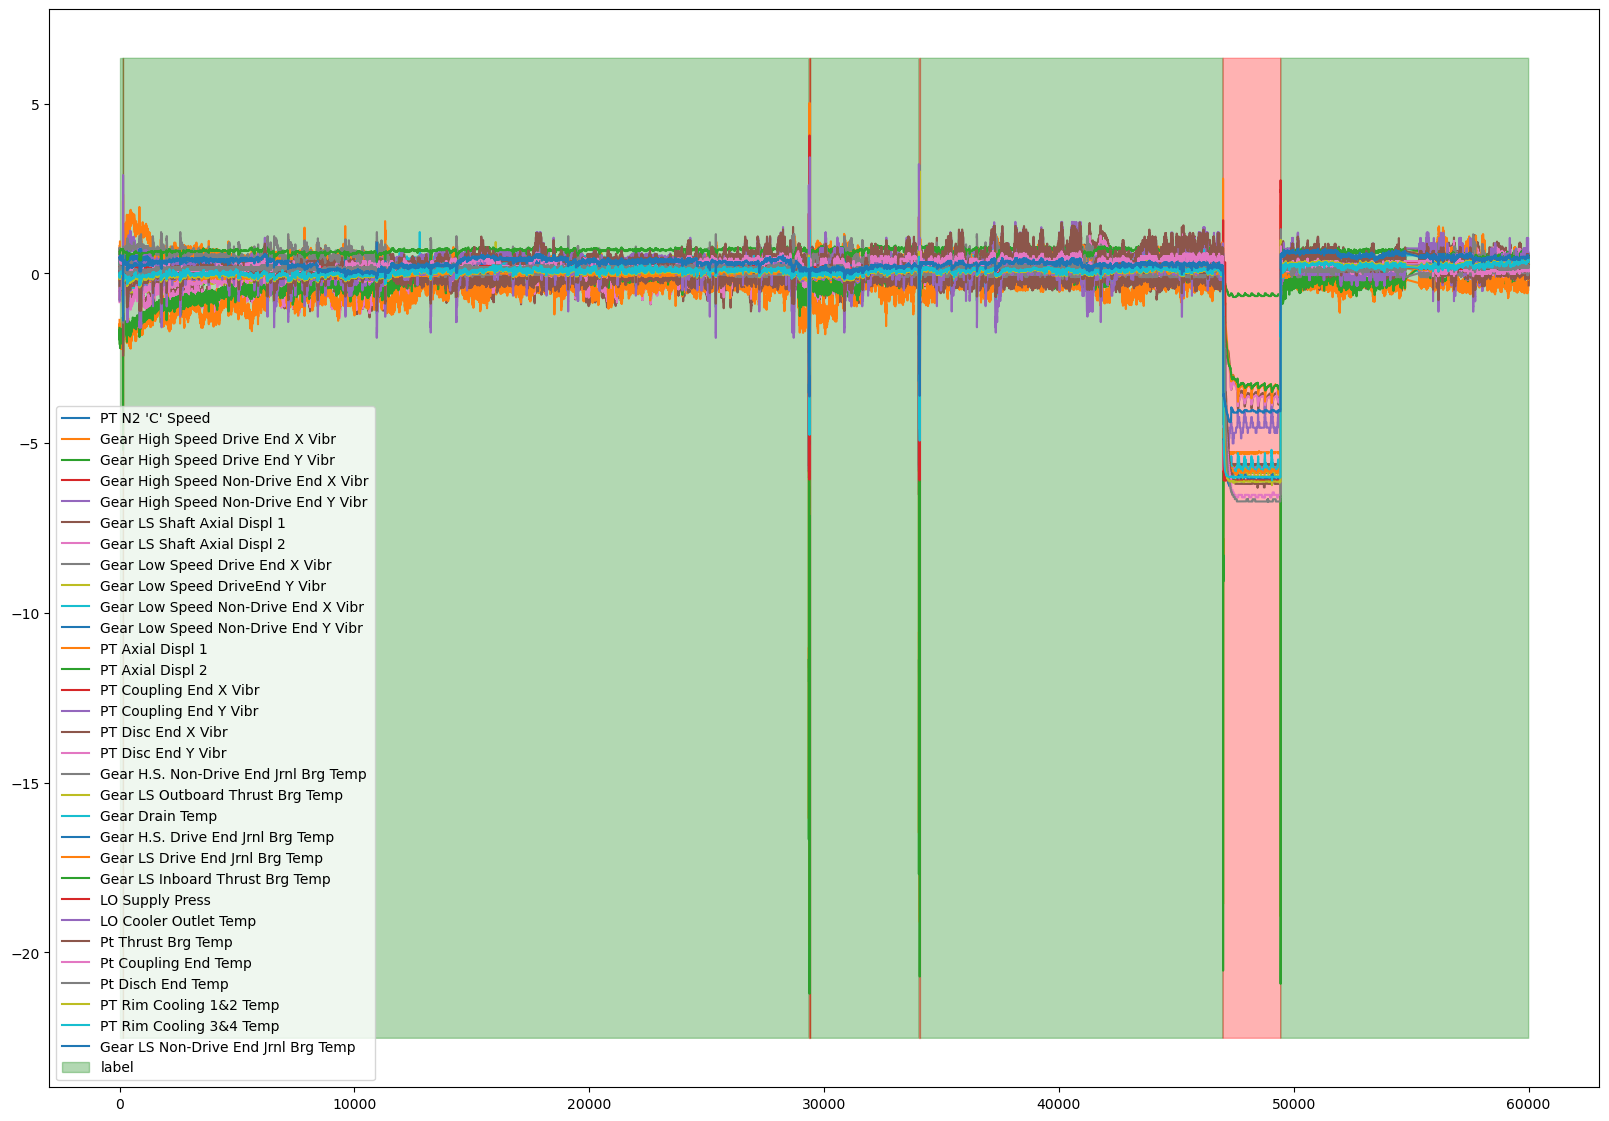

In [21]:
plt.figure(figsize=(20,14))
plt.plot(df_sample_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_scaled.shape[0]), ymin, ymax, where=(df_sample['label'] == 1), color='red', alpha=0.3)
plt.legend(df_sample.columns)
plt.plot()

In [ ]:
df_sample.loc[df_sample['label'] == 0,:].shape

(57449, 32)

In [23]:
df_sample_scaled = scaler.transform(df_sample.loc[df_sample['label'] == 0,:].drop("label", axis=1))

[]

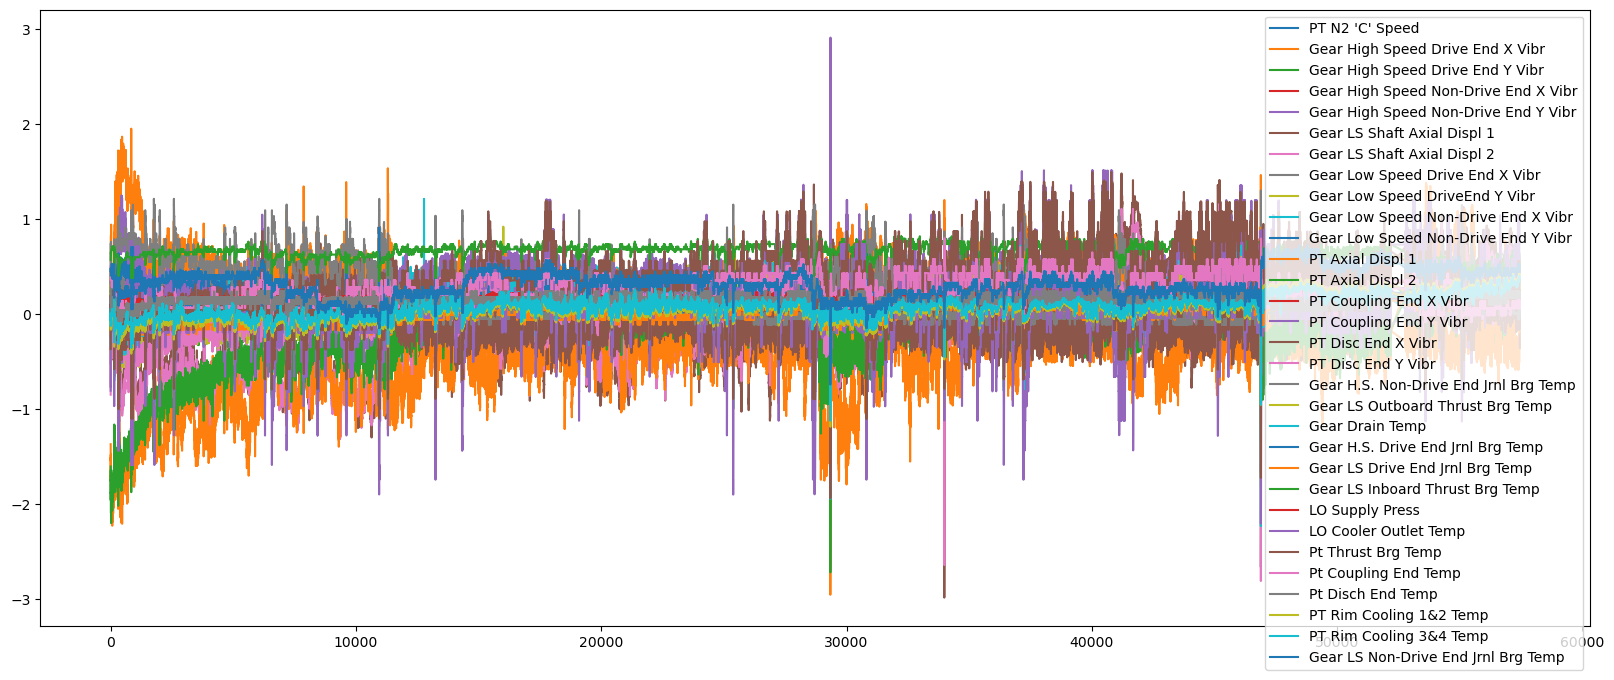

In [24]:
plt.figure(figsize=(20,8))
plt.plot(df_sample_scaled)
plt.legend(df_sample.columns)
plt.plot()

In [25]:
df_sample_scaled_3d = convert_time_window(df_sample_scaled, 10)

In [26]:
def create_lstm_autoencoder(timesteps, n_features):
    # Encoder
    input_layer = keras.layers.Input(shape=(timesteps, n_features))
    encoder = keras.layers.LSTM(32, return_sequences=True)(input_layer)
    encoder = keras.layers.LSTM(32, return_sequences=True)(encoder)
    encoder = keras.layers.LSTM(16, return_sequences=True)(encoder)
    encoder = keras.layers.Flatten()(encoder)
    encoder = keras.layers.Dense(16, activation='relu')(encoder)
    encoded_output = keras.layers.Dense(8, activation='relu')(encoder)

    # Decoder
    decoder = keras.layers.Dense(8, activation='relu')(encoded_output)
    decoder = keras.layers.Dense(16, activation='relu')(decoder)
    decoder = keras.layers.RepeatVector(timesteps)(decoder)

    decoder = keras.layers.LSTM(16, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)
    decoder = keras.layers.LSTM(32, return_sequences=True)(decoder)

    decoded_output = keras.layers.TimeDistributed(keras.layers.Dense(n_features))(decoder)

    # Define the full autoencoder model
    autoencoder = keras.models.Model(inputs=input_layer, outputs=decoded_output, name="Autoencoder")

    return autoencoder



In [27]:
with tf.device('/GPU:0'):
    lstm_model = create_lstm_autoencoder(10, df_sample_scaled.shape[1])
lstm_model.summary()

2024-10-17 10:17:44.079157: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 10:17:44.079311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 10:17:44.079357: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 10:17:45.460315: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-17 10:17:45.460344: I tensorflow/core/common_runtime/gpu/gpu

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            8192      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            3136      
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 16)                2576      
                                                                 
 dense_1 (Dense)             (None, 8)                 

In [28]:
def myCallbacks(log_dir):
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='loss',
    patience=10,
    mode='min')
    model_path = os.path.join(log_dir,'best_model.h5')
    mc = tf.keras.callbacks.ModelCheckpoint(model_path, monitor='loss', mode='min', verbose=1, save_best_only=False)
    return [tensorboard_callback, early_stopping, mc]

In [29]:
lstm_model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=['acc'])

In [30]:
with tf.device('/GPU:0'):
    history = lstm_model.fit(
        df_sample_scaled_3d, df_sample_scaled_3d, 
        callbacks=myCallbacks('../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64'), 
        epochs=20, 
        batch_size=64)

Epoch 1/20


2024-10-17 10:17:52.238465: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-10-17 10:17:52.721512: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7ff0bbdf90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-17 10:17:52.721555: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA T500, Compute Capability 7.5
2024-10-17 10:17:52.726110: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1729135072.796925   72784 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


897/898 [============================>.] - ETA: 0s - loss: 0.0217 - acc: 0.7642
Epoch 1: saving model to ../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5
898/898 [==============================] - 28s 25ms/step - loss: 0.0217 - acc: 0.7642
Epoch 2/20
  4/898 [..............................] - ETA: 20s - loss: 0.0108 - acc: 0.8109

/home/farras/miniconda3/envs/tensor_gpu/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


897/898 [============================>.] - ETA: 0s - loss: 0.0095 - acc: 0.8468
Epoch 2: saving model to ../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5
898/898 [==============================] - 23s 26ms/step - loss: 0.0095 - acc: 0.8468
Epoch 3/20
897/898 [============================>.] - ETA: 0s - loss: 0.0081 - acc: 0.8567
Epoch 3: saving model to ../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5
898/898 [==============================] - 24s 26ms/step - loss: 0.0081 - acc: 0.8568
Epoch 4/20
898/898 [==============================] - ETA: 0s - loss: 0.0074 - acc: 0.8723
Epoch 4: saving model to ../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5
898/898 [==============================] - 26s 29ms/step - loss: 0.0074 - acc: 0.8723
Epoch 5/20
898/898 [==============================]

## ============================================

In [31]:
lstm_model = keras.models.load_model("../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5")
train_3d_np = lstm_model.predict(df_sample_scaled_3d)
train_2d_np = inverse_convert_time_window(train_3d_np)

1795/1795 [==============================] - 13s 7ms/step


In [32]:
r_e = calculate_reconstruction_loss(df_sample_scaled, train_2d_np)

In [33]:
print("Max: ", np.max(r_e))
print("Min: ", np.min(r_e))
print("Avg: ", np.mean(r_e))
print("Median: ", np.median(r_e))
print("75%: ", np.percentile(r_e, 75))
print("25%: ", np.percentile(r_e, 25))
print("IQR: ", np.percentile(r_e, 75) - np.percentile(r_e, 25))

Max:  0.6021962490821913
Min:  0.015205745296916819
Avg:  0.039600564021827184
Median:  0.03761504437888867
75%:  0.044460982336645256
25%:  0.03232293885346103
IQR:  0.012138043483184223


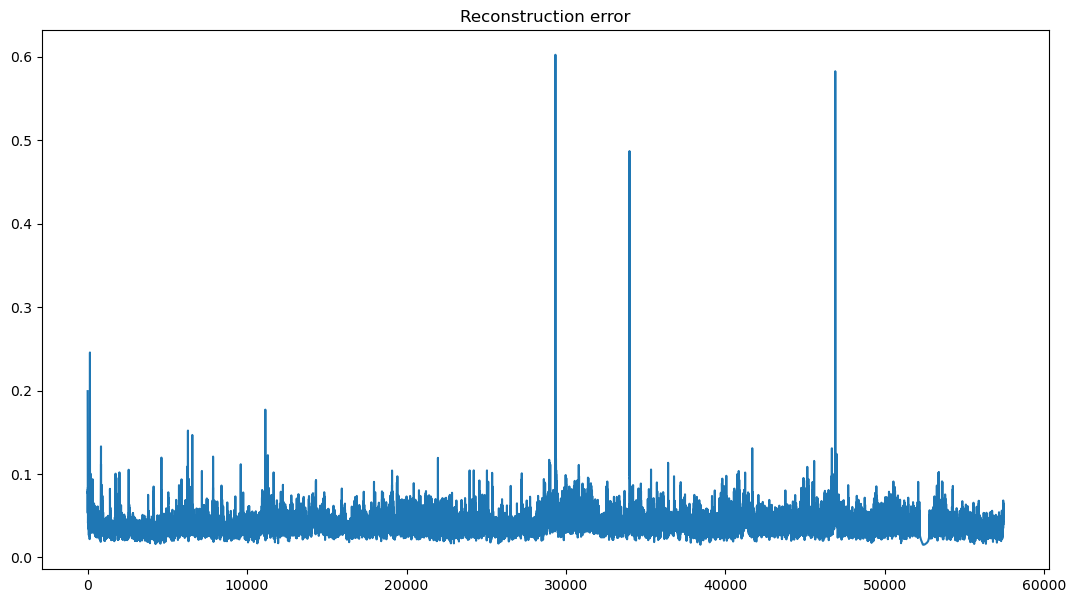

In [34]:
plt.figure(figsize=(13,7))
plt.plot(r_e)
# plt.plot(np.full(r_e.shape[0], thres))
# xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.arange(thres-iqr, thres+iqr), r_e.shape[0], color='gray', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

In [22]:
pd.DataFrame(r_e).to_csv("../../reconstruction_error/gearbox/reconstruction_error.csv", index=False)

## ===============================================

In [185]:
df_sample_test = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [186]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -3) | (df_sample_test_scaled > 3), axis=1), 1, 0)

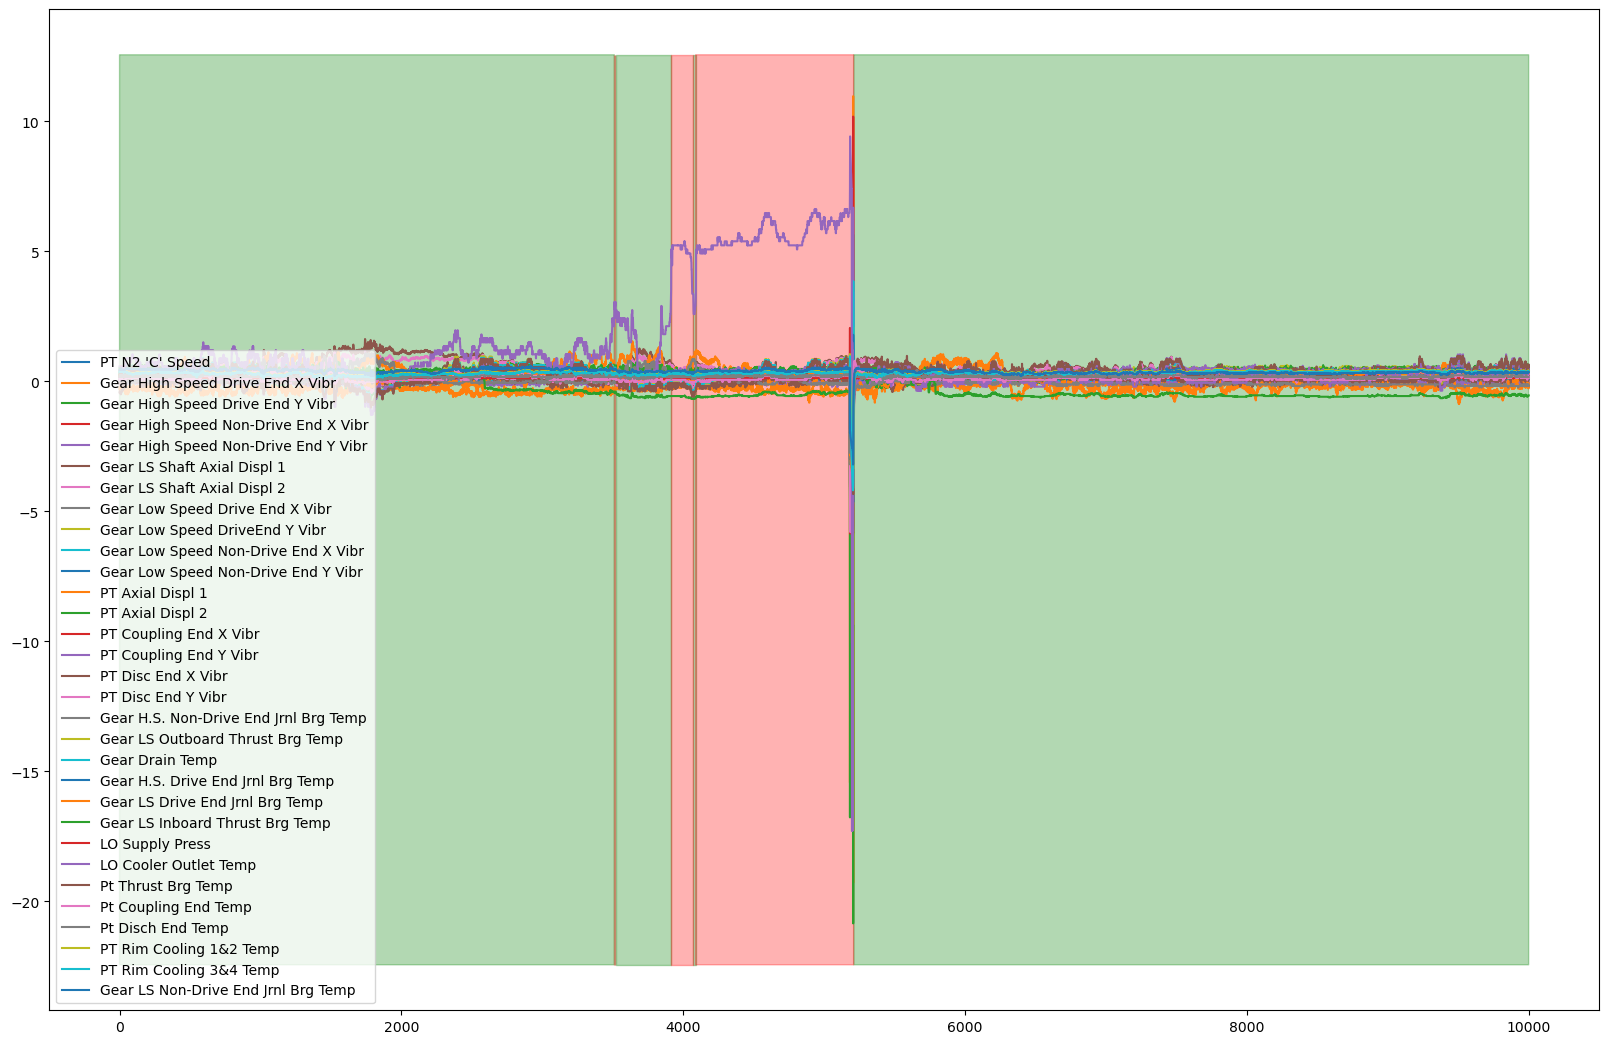

In [187]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

In [188]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)

In [189]:
df_sample_test_scaled_3d.shape

(9991, 10, 31)

In [190]:
model = keras.models.load_model("../../models/turbine-gas-gearbox/LSTM-Autoencoder/model-LSTM_32-32-16_flatten_latent-16-8_t-10_batch-64/best_model.h5")
model.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 31)]          0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            8192      
                                                                 
 lstm_1 (LSTM)               (None, 10, 32)            8320      
                                                                 
 lstm_2 (LSTM)               (None, 10, 16)            3136      
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                                 
 dense (Dense)               (None, 16)                2576      
                                                                 
 dense_1 (Dense)             (None, 8)                 

In [191]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)
pred_full = model.predict(df_sample_test_scaled_3d)

313/313 [==============================] - 4s 8ms/step


In [192]:
pred_64 = model.predict(df_sample_test_scaled_3d[3800:3864])

2/2 [==============================] - 0s 8ms/step


In [221]:
df_sample_test_scaled_3d[3800:3810].shape

(10, 10, 31)

In [193]:
print(pred_64.shape)

(64, 10, 31)


In [194]:
pred_2d_inv = inverse_convert_time_window(pred_64)
print(pred_2d_inv.shape)
# r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)

(73, 31)


In [195]:
df_sample_test_scaled_3d_single = df_sample_test_scaled_3d[3800, :, :]
pred_single = model.predict(df_sample_test_scaled_3d_single.reshape(1, -1, df_sample_test_scaled_3d_single.shape[1]))

1/1 [==============================] - 0s 45ms/step


In [196]:
df_sample_test_scaled_3d_10 = df_sample_test_scaled_3d[3800:3810, :, :]
pred_10 = model.predict(df_sample_test_scaled_3d_10)

1/1 [==============================] - 0s 24ms/step


In [219]:
df_sample_test_scaled_3d_16 = df_sample_test_scaled_3d[3800:3816, :, :]
pred_16 = model.predict(df_sample_test_scaled_3d_16)

1/1 [==============================] - 0s 26ms/step


In [197]:
df_sample_test_scaled_3d_32 = df_sample_test_scaled_3d[3800:3832, :, :]
pred_32 = model.predict(df_sample_test_scaled_3d_32)

1/1 [==============================] - 0s 22ms/step


In [198]:
pred_32.shape

(32, 10, 31)

In [199]:
pred_10.shape

(10, 10, 31)

In [200]:
pred_single.shape

(1, 10, 31)

In [201]:
pred_full.shape

(9991, 10, 31)

In [138]:
pred_2d_inv_single = inverse_convert_time_window(pred_single)

In [139]:
pred_2d_inv_single.shape

(10, 31)

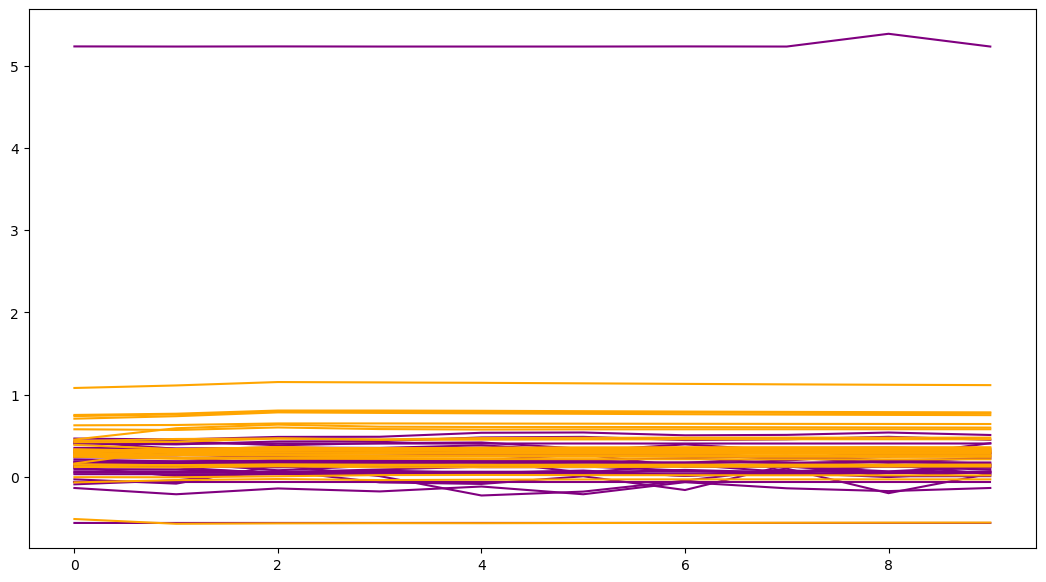

In [104]:
plt.figure(figsize=(13,7))
plt.plot(inverse_convert_time_window(df_sample_test_scaled_3d_4000.reshape(1, -1, df_sample_test_scaled_3d_4000.shape[1])), color='purple')
plt.plot(pred_2d_inv_single, color='orange')
plt.show()

In [144]:
pred_single.shape

(1, 10, 31)

In [202]:
from sklearn.metrics import r2_score

print("Single vs 64")
print(r2_score(pred_64[0], pred_single.reshape(pred_single.shape[1], pred_single.shape[2])))

Single vs 64
0.9999999997173549


In [204]:
print("10K vs single")
print(r2_score(pred_full[3800], pred_single.reshape(pred_single.shape[1], pred_single.shape[2])))

10K vs single
0.9999999997173549


In [205]:
print("32 vs single")
print(r2_score(pred_32[0], pred_single.reshape(pred_single.shape[1], pred_single.shape[2])))

32 vs single
0.9999999997173549


In [210]:
pred_64.shape

(64, 10, 31)

In [222]:
pred_full_inv_16 = inverse_convert_time_window(pred_full[3800:3816])
pred_16_inv = inverse_convert_time_window(pred_16)

print("10K vs 16")
print(r2_score(pred_full_inv_16, pred_16_inv))

10K vs 16
0.9999999999882199


In [214]:
pred_full_inv_64 = inverse_convert_time_window(pred_full[3800:3864])
pred_64_inv = inverse_convert_time_window(pred_64)

print("10K vs 64")
print(r2_score(pred_full_inv_64, pred_64_inv))

10K vs 64
1.0


In [215]:
pred_full_inv_32 = inverse_convert_time_window(pred_full[3800:3832])
pred_32_inv = inverse_convert_time_window(pred_32)

print("10K vs 32")
print(r2_score(pred_full_inv_32, pred_32_inv))

10K vs 32
1.0


In [218]:
print("10K vs 32")
print(r2_score(pred_64_inv[:41], pred_32_inv))

10K vs 32
0.9517111346217394


In [216]:
pred_full_inv_10 = inverse_convert_time_window(pred_full[3800:3810])
pred_10_inv = inverse_convert_time_window(pred_10)

print("10K vs 10")
print(r2_score(pred_full_inv_10, pred_10_inv))

10K vs 10
0.999999999980425


In [169]:
# pred[0].shape

(10, 31)

In [173]:
print("10 vs single")
print(r2_score(pred_10[0], pred_single.reshape(pred_single.shape[1], pred_single.shape[2])))

10 vs single
0.9999999999754464


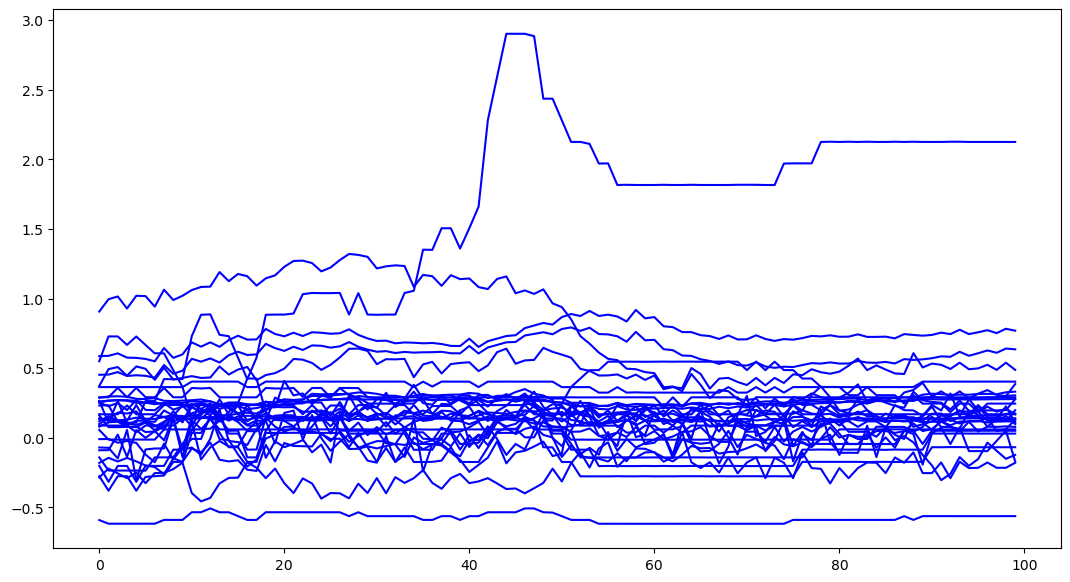

In [229]:
plt.figure(figsize=(13,7))
plt.plot(df_sample_test_scaled[3800:3900], color='blue', label='real')
# plt.plot(pred_full_inv_32, color='purple', label='single data pred')
# plt.plot(pred_32_inv, color='orange', label='multiple data pred')
# plt.legend()
plt.show()

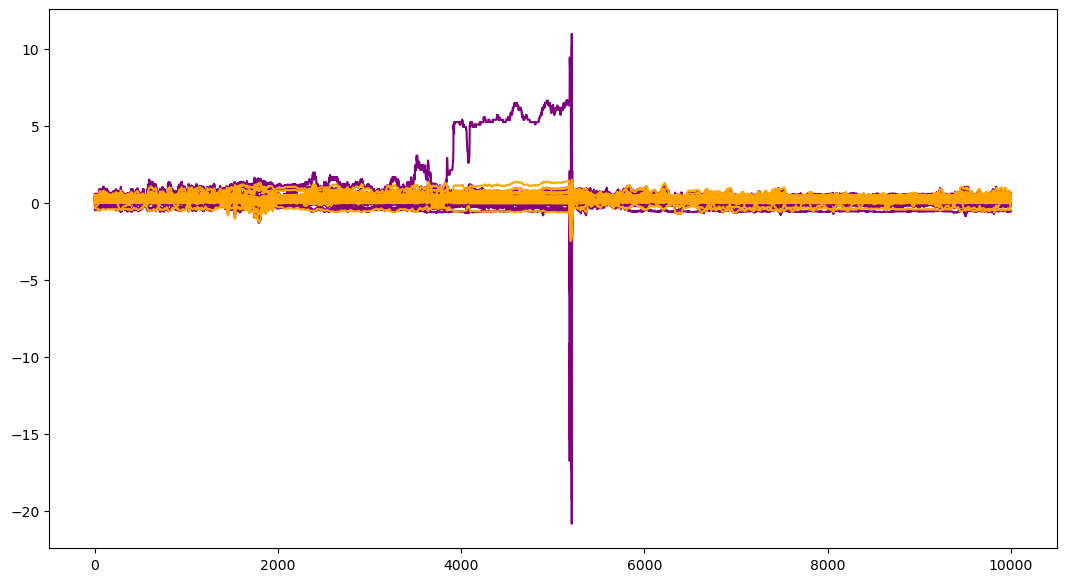

In [85]:
plt.figure(figsize=(13,7))
plt.plot(df_sample_test_scaled, color='purple')
plt.plot(pred_2d_inv, color='orange')
plt.show()

In [87]:
r_e = calculate_reconstruction_loss(df_sample_test_scaled, pred_2d_inv)
# thres = 0.5831722671849883
# thres = 0.03036027381691517
# thres = 0.034154447668272886 + (1.5 * 0.008287947844526241)
thres =  0.6828104323825716

In [88]:
# df_sample_test_label = df_sample_test_label[3800:4500]

thres, f1, y_pred = find_optimal_threshold((r_e), np.array(df_sample_test_label))
print(thres, f1)

0.26365830499534265 0.9981886000466075


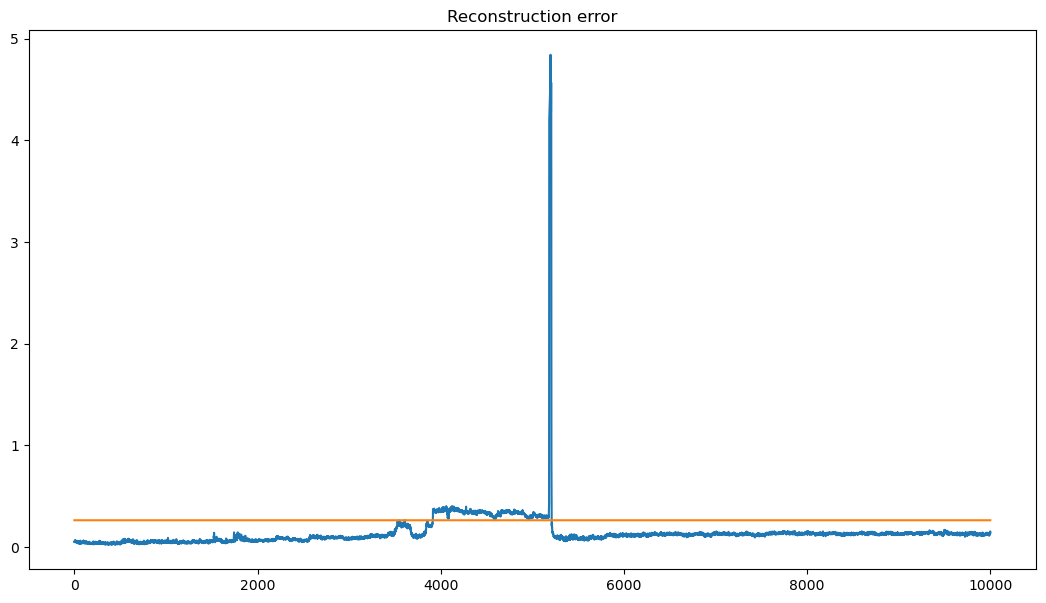

In [89]:
# iqr = np.percentile(r_e, 75) - np.percentile(r_e, 25)

plt.figure(figsize=(13,7))
plt.plot(r_e)
plt.plot(np.full(r_e.shape[0], thres))
xmin, xmax, ymin, ymax = plt.axis()
# plt.fill_betweenx(np.arange(thres-iqr, thres+iqr), r_e.shape[0], color='gray', alpha=0.3)
plt.title("Reconstruction error")
plt.show()

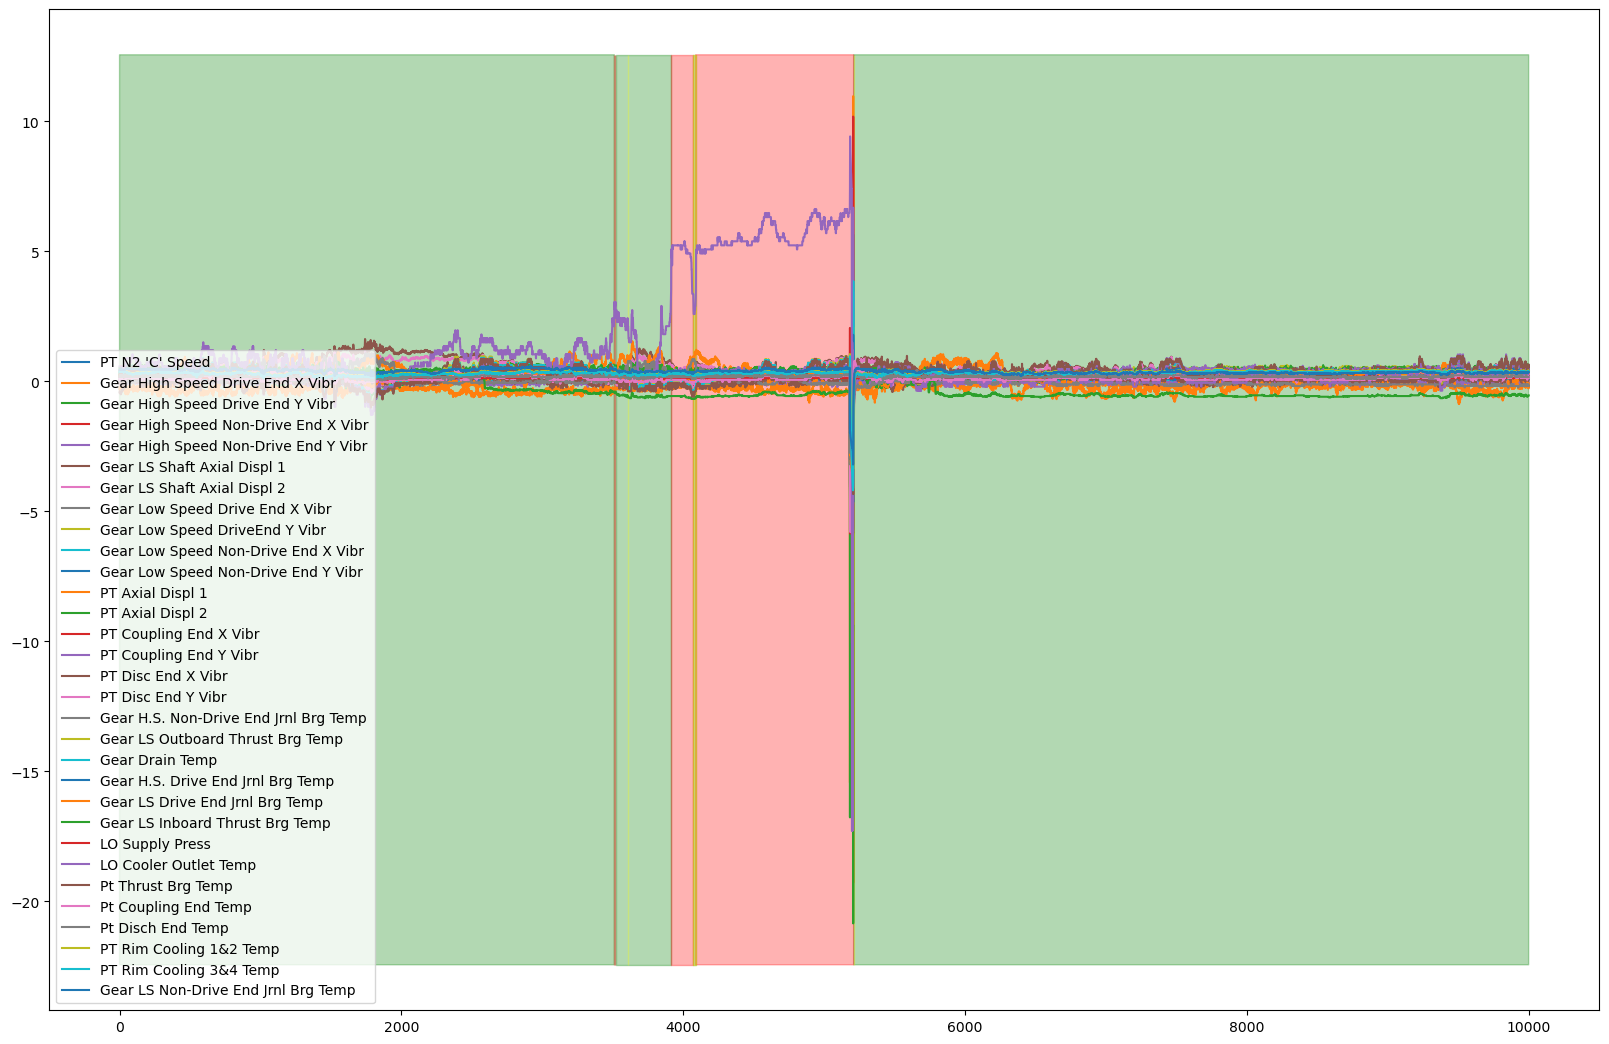

In [90]:
# df_sample_test_label = df_sample_test_label[3500:4100]
# df_sample_test_scaled = df_sample_test_scaled[3500:4100,:]

plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.fill_between(np.arange(0,df_sample_test_scaled.shape[0]), ymin, ymax,where=(~df_sample_test_label.astype(bool) & y_pred ), color='yellow', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

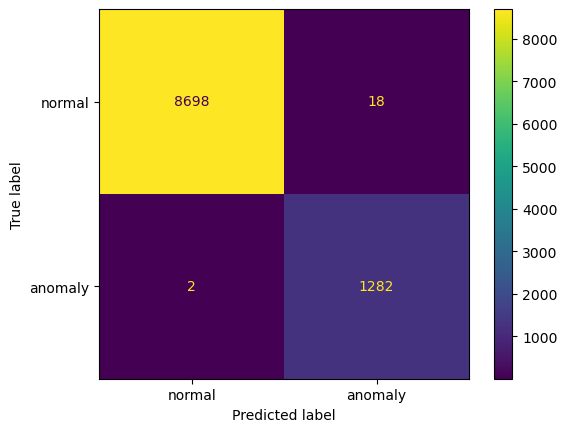

In [48]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(np.array(df_sample_test_label).astype(bool), y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ['normal', 'anomaly'])
cm_display.plot()

In [49]:
print("Accuracy: ", metrics.accuracy_score(np.array(df_sample_test_label).astype(bool), y_pred))
print("F1-score: ", metrics.f1_score(np.array(df_sample_test_label).astype(bool), y_pred))

Accuracy:  0.998
F1-score:  0.9922600619195047


## =======================

In [52]:
df_sample_test = pd.read_csv("../../datasets/turbine-gas-gearbox/data_sample_test.csv", index_col="Timestamp")
scaler_test = pickle.load(open('StandardScaler-gearbox.pkl', 'rb'))
df_sample_test_scaled = scaler_test.transform(df_sample_test)

In [53]:
df_sample_test_label = np.where(np.any((df_sample_test_scaled < -3) | (df_sample_test_scaled > 3), axis=1), 1, 0)

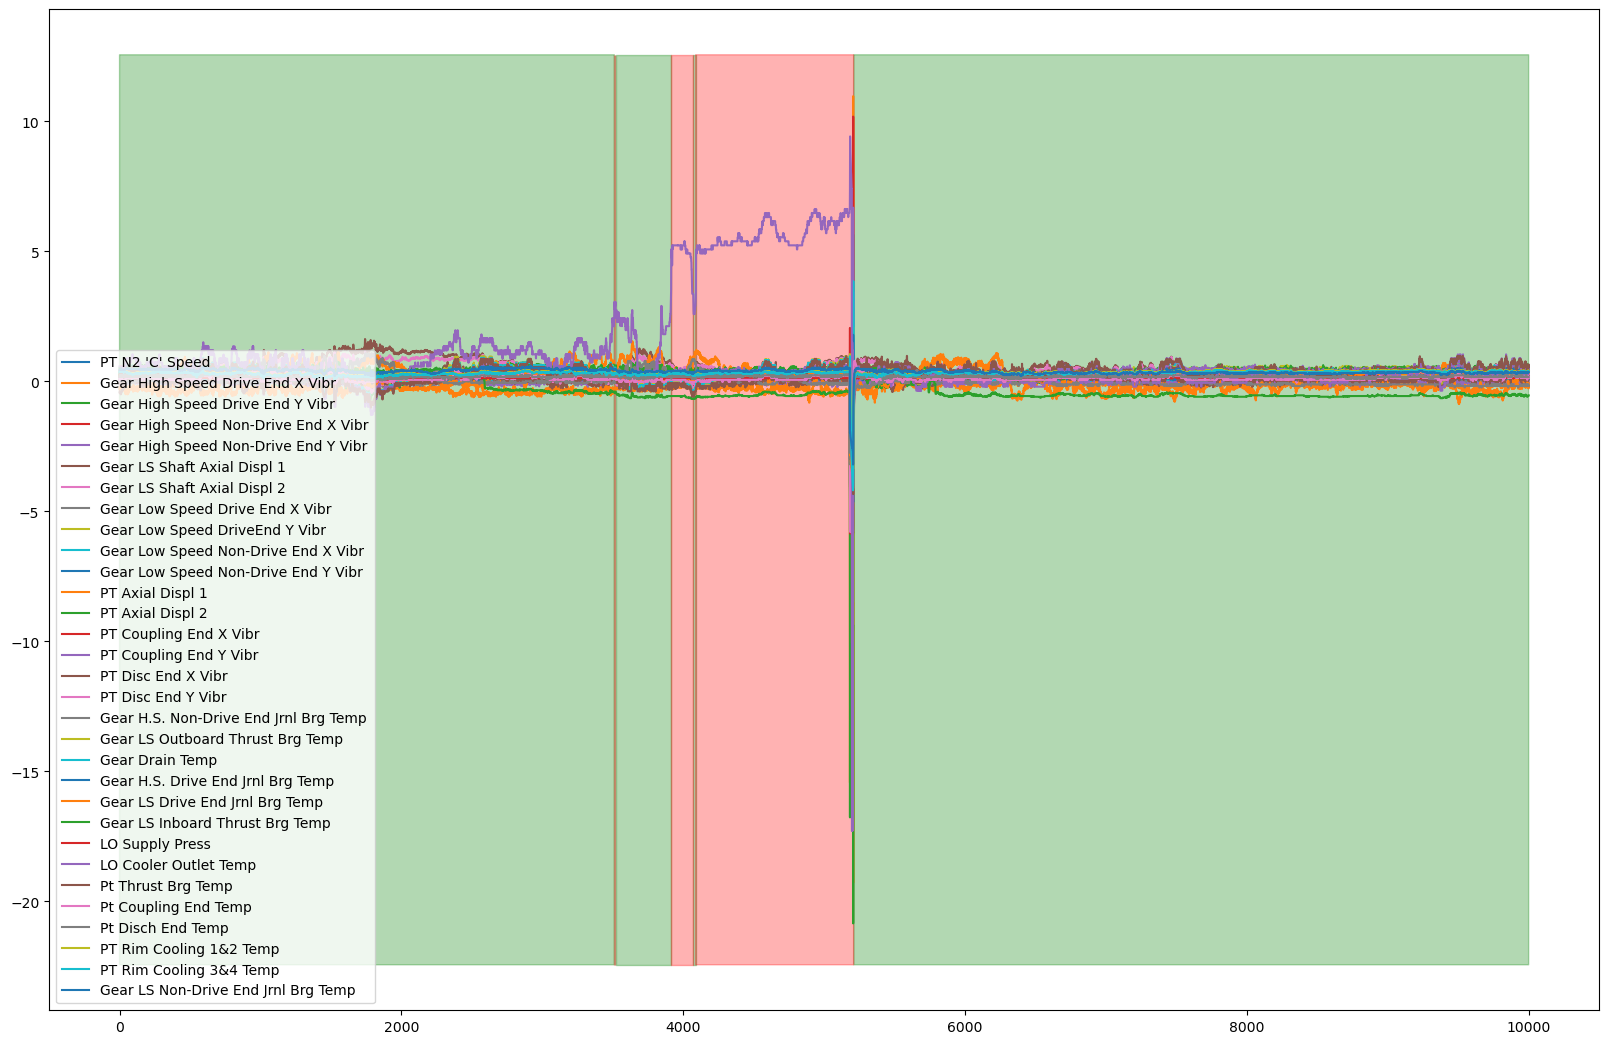

In [54]:
plt.figure(figsize=(20,13))
plt.plot(df_sample_test_scaled)
xmin, xmax, ymin, ymax = plt.axis()
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 0), color='green', alpha=0.3)
plt.fill_between(np.arange(0, df_sample_test_scaled.shape[0]), ymin, ymax, where=(df_sample_test_label == 1), color='red', alpha=0.3)
plt.legend(df_sample_test.columns)
plt.show()

In [ ]:
df_sample_test_scaled_3d = convert_time_window(df_sample_test_scaled, 10)